**Stage 0: Set up**     
(Importing the modules required) 

In [1]:
import pandas as pd
from google.colab import files
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing as pp
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
! pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt


     |████████████████████████████████| 112kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions

**Stage 1: Data-preprocessing**

1.1 Loading any required dataset

In [7]:
#Any dataset of the user's choice can be uploaded by changing file name 
#df = pd.read_excel("df_stud_simplest_train.xlsx")
from google.colab import files
uploaded = files.upload()
name="df_stud_simplest_train_PP.xlsx"
df = pd.read_excel(name)

Saving df_stud_simplest_train_PP.xlsx to df_stud_simplest_train_PP (1).xlsx


1.2 Imputing the dataset to fill any missing values, if the datset uploaded was incomplete. 

In [8]:
choice_for_missing_data = int(input("If there are missing values in the dataset, you can choose to either impute (enter '1') them or to use only rows without missing data (enter '0'). "))
if (choice_for_missing_data == 1):
  df.replace(r'^\s*$', np.nan, regex=True)
  imputer = KNNImputer(n_neighbors=2)
  filled = imputer.fit_transform(df)
  df_filled = pd.DataFrame(filled, columns = df.columns)
  df_filled = df_filled.drop(columns="index")
  if (df_filled.isnull().sum().sum() == 0 ):
    print("Dataset has been succesfully imputed.")
    print(df_filled)
elif (choice_for_missing_data == 0):
  df.dropna(axis = 0, how='any',inplace=True)
  df_filled = df.copy(deep='True')
  if (df.isnull().sum().sum() == 0 ):
    print("Dataset has been succesfully imputed.")
    print(df_filled)
else:
  print("Wrong input for choice, enter either 0 or 1")



If there are missing values in the dataset, you can choose to either impute (enter '1') them or to use only rows without missing data (enter '0'). 0
Dataset has been succesfully imputed.
       ComplexConvergenceDum  NSolutions  ...  GroupDum  high_std_experience_dum
10                         0          32  ...         1                      0.0
23                         0          15  ...         1                      0.0
66                         0         271  ...         1                      1.0
103                        0          24  ...         1                      0.0
188                        0           6  ...         1                      0.0
...                      ...         ...  ...       ...                      ...
57735                      0           4  ...         1                      0.0
57796                      0          77  ...         1                      0.0
57843                      0          68  ...         1                      1.0
578

1.3 Splitting the dataset

In [9]:
#Splitting dataset equally into train and test 

target_name = input("Enter column name that is the target variable:") 

X_train_df = df_filled.copy(deep=True)
selected_columns = X_train_df[[target_name]]
Y_train_df = selected_columns.copy()
X_train_df = X_train_df.drop(columns=target_name)


Enter column name that is the target variable:PrivateLeaderboardScore


**Stage 2: Feature selection and polynomial creation**

2.1 Hyperparameter tuning of random forest and MLP using K-fold cross-validation

In [10]:
type_of_data = int(input("Enter 1 the target variable is categorical. Enter 0 if the target variable is continuous: "))
if (type_of_data == 1):
  rf = RandomForestClassifier()
  mlp = MLPClassifier(max_iter=100)
elif (type_of_data == 0):
  rf = RandomForestRegressor()
  mlp = MLPRegressor(max_iter=100)

Enter 1 the target variable is categorical. Enter 0 if the target variable is continuous: 0


In [11]:
print('Parameters currently in use, before hyperparameter tuning:\n')
pprint(rf.get_params())

# All possibile values each parameter can take

# Number of trees in random forest
n_estimators = []
n_estimators.append((int(input("Enter number of estimators, ie. number of trees in random forest:"))))

# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = []
max_depth.append((int(input("Enter a number from 1-10 for maximum number of levels in a tree:"))))
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print("Randomised grid to test for the best hyperparameter:\n")
pprint(random_grid)


  
# Random search using grid of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_df, Y_train_df)
print("\n The best parameters for the random forest, after hyperparameter tuning are:")
pprint(rf_random.best_params_)

feature_list = list(X_train_df.columns)
importances = list(rf_random.best_estimator_.feature_importances_)

feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
print("\n Features and their importance:")
pprint(feature_importances)

Parameters currently in use, before hyperparameter tuning:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Enter number of estimators, ie. number of trees in random forest:50
Enter a number from 1-10 for maximum number of levels in a tree:4
Randomised grid to test for the best hyperparameter:

{'bootstrap': [True],
 'max_depth': [4],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50]}
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 The best parameters for the random forest, after hyperparameter tuning are:
{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

 Features and their importance:
[('NSolutions', 0.4545),
 ('QualitativeDivergence', 0.4128),
 ('std_experience', 0.0478),
 ('high_std_experience_dum', 0.0245),
 ('avg_experience', 0.0211),
 ('GroupSize', 0.0164),
 ('NumScoredSubmissions', 0.0095),
 ('skew_gold_dum_pri_count', 0.006),
 ('skew_experience', 0.0041),
 ('convergence_var', 0.0021),
 ('ComplexConvergenceDum', 0.0006),
 ('std_gold_dum_pri_count', 0.0006),
 ('avg_gold_dum_pri_count', 0.0),
 ('GroupDum', 0.0)]


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [12]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'alpha': [0.0001, 0.05],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_df, Y_train_df)

# Best parameter set
print('Best parameters found:\n')
pprint(clf.best_params_)
print('\n')


perm = PermutationImportance(clf.best_estimator_).fit(X_train_df,Y_train_df)
eli5.show_weights(perm, feature_names = X_train_df.columns.tolist())




/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best parameters found:

{'alpha': 0.0001, 'hidden_layer_sizes': (100,)}




Weight,Feature
0.2460 ± 0.0298,NSolutions
0.0697 ± 0.0176,QualitativeDivergence
0.0691 ± 0.0232,avg_gold_dum_pri_count
0.0528 ± 0.0343,high_std_experience_dum
0.0444 ± 0.0094,std_gold_dum_pri_count
0.0388 ± 0.0109,avg_experience
0.0353 ± 0.0099,std_experience
0.0351 ± 0.0087,convergence_var
0.0133 ± 0.0073,NumScoredSubmissions
0.0120 ± 0.0097,skew_experience


In [13]:
num_required_features = int(input("How many variables do you want to select? "))
req_feature_list = [] 
print("\n")
for i in range (0,num_required_features):
  feature_choice = input("Enter required feature: ")
  req_feature_list.append(feature_choice) 
   

How many variables do you want to select? 4


Enter required feature: ComplexConvergenceDum
Enter required feature: NSolutions
Enter required feature: QualitativeDivergence
Enter required feature: avg_gold_dum_pri_count


2.2 Creating modified dataframe with only the required features the user has selected

In [14]:
req_feature_df = pd.DataFrame(req_feature_list)
col_names = list(X_train_df.columns)

X_train_selected_features_df= X_train_df.copy(deep=True)
for col_name in col_names:
    if col_name not in req_feature_list:
        X_train_selected_features_df = X_train_selected_features_df.drop(columns=col_name,inplace=False)

X_train_selected_features_df

,ComplexConvergenceDum,NSolutions,QualitativeDivergence,avg_gold_dum_pri_count
10,0,32,0.115516,0.0
23,0,15,1.298079,0.0
66,0,271,0.027853,4.0
103,0,24,0.044433,0.0
188,0,6,0.349953,0.0
...,...,...,...,...
57735,0,4,0.000000,0.0
57796,0,77,0.728924,0.0
57843,0,68,0.096943,0.0
57864,0,22,0.385915,0.0


2.3 Creating all terms of a polynomial of degree specified by the user

In [15]:
polynomial_degree = int(input("Enter maximum degree of required polynomial: "))

Enter maximum degree of required polynomial: 2


In [16]:
#creating new dataframe with all possibile polynomial terms 

selected_feature_df = pd.DataFrame(X_train_selected_features_df.columns)
cols = selected_feature_df.columns.tolist()
def PolynomialFeatureNames(sklearn_feature_name_output, df):
  import re 
  cols = df.columns.tolist()
  feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
  feat_string = ','.join(sklearn_feature_name_output)
  for k,v in feat_map.items():
    feat_string = re.sub(fr"\b{k}\b",v,feat_string)
  return feat_string.replace(" "," x ").split(',')  

interaction = pp.PolynomialFeatures(polynomial_degree)
X_inter = interaction.fit_transform(X_train_selected_features_df)
names = PolynomialFeatureNames(interaction.get_feature_names(),X_train_selected_features_df)

X_inter_df = pd.DataFrame(X_inter,columns= names)
X_inter_df

,1,ComplexConvergenceDum,NSolutions,QualitativeDivergence,avg_gold_dum_pri_count,ComplexConvergenceDum^2,ComplexConvergenceDum x NSolutions,ComplexConvergenceDum x QualitativeDivergence,ComplexConvergenceDum x avg_gold_dum_pri_count,NSolutions^2,NSolutions x QualitativeDivergence,NSolutions x avg_gold_dum_pri_count,QualitativeDivergence^2,QualitativeDivergence x avg_gold_dum_pri_count,avg_gold_dum_pri_count^2
0,1.0,0.0,32.0,0.115516,0.0,0.0,0.0,0.0,0.0,1024.0,3.696509,0.0,0.013344,0.000000,0.0
1,1.0,0.0,15.0,1.298079,0.0,0.0,0.0,0.0,0.0,225.0,19.471191,0.0,1.685010,0.000000,0.0
2,1.0,0.0,271.0,0.027853,4.0,0.0,0.0,0.0,0.0,73441.0,7.548205,1084.0,0.000776,0.111413,16.0
3,1.0,0.0,24.0,0.044433,0.0,0.0,0.0,0.0,0.0,576.0,1.066390,0.0,0.001974,0.000000,0.0
4,1.0,0.0,6.0,0.349953,0.0,0.0,0.0,0.0,0.0,36.0,2.099715,0.0,0.122467,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,1.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,0.0,16.0,0.000000,0.0,0.000000,0.000000,0.0
1735,1.0,0.0,77.0,0.728924,0.0,0.0,0.0,0.0,0.0,5929.0,56.127144,0.0,0.531330,0.000000,0.0
1736,1.0,0.0,68.0,0.096943,0.0,0.0,0.0,0.0,0.0,4624.0,6.592124,0.0,0.009398,0.000000,0.0
1737,1.0,0.0,22.0,0.385915,0.0,0.0,0.0,0.0,0.0,484.0,8.490119,0.0,0.148930,0.000000,0.0


**Stage 3: Selecting important polynomial terms** 



Stage 3.1 Using K-fold cross validation to find best regularization parameter of the lasso model. 

In [17]:
lasso = Lasso()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 5)
lasso_regressor.fit(X_inter_df,Y_train_df)

print("Best parameter value is:", lasso_regressor.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204.2560068435523, tolerance: 0.04611214917020441
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.1325230806634, tolerance: 0.04536885143467134
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176.04295591213042, tolerance: 0.041248792791679346
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207.

Best parameter value is: {'alpha': 0.01}


Stage 3.2 Displaying the coeffecients of each polynomial term, and the user selects what terms to keep. 

In [18]:
#coeffiecients when lasso with the best hyper parameter is fitted
coefficients = list(lasso_regressor.best_estimator_.coef_)
feature_coefficients = [(name, round(coefficient, 20)) for name, coefficient in zip(names, coefficients)]

#sorting the coefficients in descending order
feature_coefficients = sorted(feature_coefficients, key = lambda x: x[1], reverse = True)

print("The coefficient of each feature in the polynomial is: \n")
feature_coefficients

The coefficient of each feature in the polynomial is: 



[('QualitativeDivergence', 0.11102623677097967),
 ('NSolutions', 0.0040267211825008396),
 ('avg_gold_dum_pri_count^2', 0.001157453053928741),
 ('NSolutions x QualitativeDivergence', 0.0011010536798848902),
 ('1', 0.0),
 ('ComplexConvergenceDum', 0.0),
 ('avg_gold_dum_pri_count', 0.0),
 ('ComplexConvergenceDum^2', 0.0),
 ('ComplexConvergenceDum x QualitativeDivergence', -0.0),
 ('ComplexConvergenceDum x avg_gold_dum_pri_count', -0.0),
 ('QualitativeDivergence x avg_gold_dum_pri_count', 0.0),
 ('NSolutions^2', -8.77954739410998e-06),
 ('NSolutions x avg_gold_dum_pri_count', -6.697921464788887e-05),
 ('ComplexConvergenceDum x NSolutions', -0.0004109132896667968),
 ('QualitativeDivergence^2', -0.017728228228042053)]

In [19]:
print("A higher coefficient indicates higher importance of a term.\n")
num_required_terms = int(input("How many terms of the polynomial do you want to select? "))
req_term_list = [] 
for j in range (0,num_required_terms):
  term_choice = input("Enter required term name: ")
  req_term_list.append(term_choice)
req_term_df = pd.DataFrame(req_term_list)
col_names_new = list(X_inter_df.columns)

X_train_selected_terms_df = X_inter_df.copy(deep = True)
for col_name_new in col_names_new:
    if col_name_new not in req_term_list:
        X_train_selected_terms_df = X_train_selected_terms_df.drop(columns=col_name_new,inplace=False)

X_train_selected_terms_df
print("The predicted polynomial is:\n")
for h in range (0,num_required_terms):
  print(req_term_list[h])
  if h != num_required_terms-1:
    print("+")


A higher coefficient indicates higher importance of a term.

How many terms of the polynomial do you want to select? 4
Enter required term name: QualitativeDivergence
Enter required term name: NSolutions
Enter required term name: avg_gold_dum_pri_count^2
Enter required term name: NSolutions x QualitativeDivergence
The predicted polynomial is:

QualitativeDivergence
+
NSolutions
+
avg_gold_dum_pri_count^2
+
NSolutions x QualitativeDivergence


**Stage 4: Creating the final polynomial**

4.1 Fitting a OLS linear regression method with the shortlisted terms through different subsamples of data

In [20]:
k = int(input("Enter number of sub-samples"))
coeff_array = np.ones((k,(len(df_filled.columns)-1)))

for g in range (0,k):
  sub_sample_data = df_filled.sample(n=int((len(X_train_df))/k ))
  X_sub_sample_df = sub_sample_data.copy(deep=True)
  selected_columns = X_sub_sample_df[[target_name]]
  Y_sub_sample_df = selected_columns.copy()
  X_sub_sample_df = X_sub_sample_df.drop(columns=target_name)
  reg = LinearRegression().fit(X_sub_sample_df, Y_sub_sample_df)
  coeff_test =np.array(reg.coef_)
  for f in range (0,(len(df_filled.columns)-1)):
    coeff_array[g][f] = coeff_test[0][f]
coeff_array_transpose = coeff_array.transpose()

Enter number of sub-samples5


4.2 Running an OLS on different sub-samples of the data, and respresenting using heatmap 

In [21]:
y_label = X_train_df.columns.to_list()
x_label = []
for r in range (0,k):
  s = "SubSample" + str(k)
  x_label.append(s)

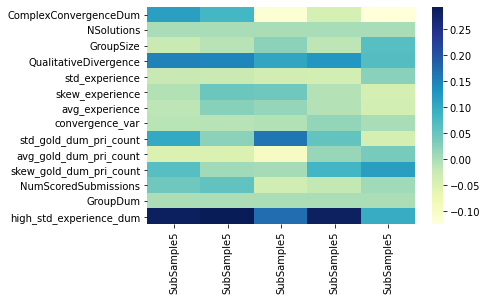

In [22]:
sns.heatmap(coeff_array_transpose, cmap="YlGnBu",yticklabels=y_label,xticklabels=x_label)